In [1]:
#Preparing the events data
import csv

csv_file_path = "./holidays_events.csv"
data_dict = {}

with open(csv_file_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=",")
    
    for row in csv_reader:
        date = row["date"]
        locale_name = row["locale_name"]
        
        if date not in data_dict:
            data_dict[date] = {}
            
        description = row["description"]
        change = None
        if '+' in description:
            if any(char.isdigit() for char in description):
                phrases = description.split("+")
                description = phrases[0]
                change = int(phrases[1])+1
        if '-' in description:
            if any(char.isdigit() for char in description):
                phrases = description.split("-")
                description = phrases[0]
                change = '-' + phrases[1]
                #print(change)
        else:
            try:
                description = description
            except ValueError:
                description = description
            
        data_dict[date][locale_name] = {
            "type": row["type"],
            "locale": row["locale"],
            "description": description,
            "transferred": row["transferred"],
            "change": change,
        }

In [2]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime
from calendar import monthrange

# Load the CSV file using pandas
train_df = pd.read_csv('train.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
# fill missing values in dcoilwtico column with previous day's value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
merged_df = pd.merge(train_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
merged_df['dcoilwtico'] = merged_df['dcoilwtico'].fillna(method='ffill')
merged_df = pd.merge(merged_df, stores_df, on='store_nbr').sort_values(by='id')

df = merged_df#pd.read_csv('train.csv')

# Extract the label column and convert to a PyTorch tensor
ids = torch.tensor(df['id'].values, dtype=torch.float)
#date = torch.tensor(df['date'].values)
store_nbr = torch.tensor(df['store_nbr'].values)
train_sales = torch.tensor(df['sales'].values, dtype=torch.float)
onpromotion = torch.tensor(df['onpromotion'].values)
dcoilwtico = torch.tensor(df['dcoilwtico'].values, dtype=torch.float)

df['event_type'] = 'regular day'
df['description'] = '0'
for index, row in df.iterrows():
    if (row['date'] in data_dict):
        if (row['city'] in data_dict[row['date']]):
            df.at[index, 'description'] = data_dict[row['date']][row['city']]['description']
            df.at[index, 'event_type'] =  data_dict[row['date']][row['city']]['type']
        if (row['state'] in data_dict[row['date']]):
            df.at[index, 'description'] = data_dict[row['date']][row['state']]['description']
            df.at[index, 'event_type']  = data_dict[row['date']][row['state']]['type']
        if ('Ecuador' in data_dict[row['date']]):
                df.at[index, 'description'] = data_dict[row['date']]['Ecuador']['description']
                df.at[index, 'event_type'] = data_dict[row['date']]['Ecuador']['type']
    else:
        df.at[index, 'event_type'] = "regular day"
#df.to_csv('merged.csv', index=False)
# Convert string dates to datetime objects
dates = pd.to_datetime(df['date'], format='%Y-%m-%d')
month = []
day_of_week = []
day_of_month = []
day_since_paycheck = []
for i in dates:
    month.append(i.month)
    day_of_week.append(i.day_of_week + 1)
    num_days_in_month = monthrange(i.year, i.month)[1]
    day_of_month.append(i.day)
    if(num_days_in_month == i.day):
        day_since_paycheck.append(0)
    else:
        if (i.day>=15):
            day_since_paycheck.append(i.day-15)
        else:
            day_since_paycheck.append(i.day)

month = torch.FloatTensor(month)
day_of_week = torch.FloatTensor(day_of_week)
day_since_paycheck = torch.FloatTensor(day_since_paycheck)
day_of_month = torch.FloatTensor(day_of_month)

#family to tensor
family = []
family_raw = df['family'].values
families = sorted(list(set(family_raw)))
family_stoi = {s:i+1 for i,s in enumerate(families)}
for i in family_raw:
    family.append(family_stoi[i])
family = torch.FloatTensor(family)

#city to tensor
city = []
city_raw = df['city'].values
cities = sorted(list(set(city_raw)))
cities_stoi = {s:i+1 for i,s in enumerate(cities)}
#cities_itos = {i:s for s,i in cities_stoi.items()}
for i in city_raw:
    city.append(cities_stoi[i])
city = torch.FloatTensor(city)

#state to tensor
state_raw = df['state'].values
state = []
states = sorted(list(set(state_raw)))
states_stoi = {s:i+1 for i,s in enumerate(states)}
for i in state_raw:
    state.append(states_stoi[i])
state = torch.FloatTensor(state)

#store type to tensor
store_type_raw = df['type'].values
store_type = []
store_types = sorted(list(set(store_type_raw)))
store_types_stoi = {s:i+1 for i,s in enumerate(store_types)}
for i in store_type_raw:
    store_type.append(store_types_stoi[i])
store_type = torch.FloatTensor(store_type)

train_event_description_raw = df['description']
train_event_description = []
event_descriptions = sorted(list(set(train_event_description_raw)))
event_descriptions_stoi = {s:i+1 for i,s in enumerate(event_descriptions)}
for i in train_event_description_raw:
    train_event_description.append(event_descriptions_stoi[i])
train_event_description = torch.FloatTensor(train_event_description)


train_event_type_raw = df['event_type']
train_event_type = []
event_types = sorted(list(set(train_event_type_raw)))
event_types_stoi = {s:i+1 for i,s in enumerate(event_types)}
for i in train_event_type_raw:
    train_event_type.append(event_types_stoi[i])
train_event_type = torch.FloatTensor(train_event_type)


cluster = torch.tensor(df['cluster'].values, dtype=torch.float)
#merged_df.to_csv('merged.csv', index=False)

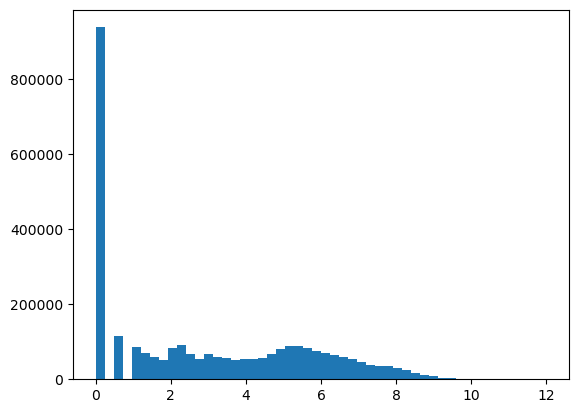

11.73381
tensor(2.6951)
0.0


In [3]:
import matplotlib.pyplot as plt
train_sales_log = np.log(train_sales+1)
data_range = train_sales_log.numpy().max() - train_sales_log.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales_log.numpy().max())+1)
plt.hist(train_sales_log.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(train_sales_log.std())
print(train_sales_log.numpy().min())

In [6]:
print(ids.shape, ids.dtype)
print(train_sales.shape, train_sales.dtype)
print(train_sales_log.shape, train_sales_log.dtype)
print(onpromotion.shape, onpromotion.dtype)
print(family.shape, family.dtype)
print(day_of_week.shape, day_of_week.dtype)
print(month.shape, month.dtype)
print(day_since_paycheck.shape, day_since_paycheck.dtype)
print(dcoilwtico.shape, dcoilwtico.dtype)
print(city.shape, city.dtype)
print(state.shape, state.dtype)
print(store_type.shape, store_type.dtype)
print(cluster.shape, cluster.dtype)
print(train_event_type.shape, train_event_type.dtype)
print(train_event_description.shape, train_event_description.dtype)

torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.int64
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32


(array([  53328.,    3564.,       0.,   98010.,       0.,   90948.,
          12837.,       0.,    8910., 2733291.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

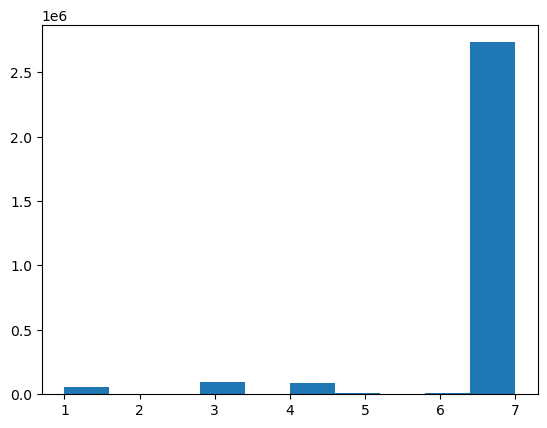

In [50]:
plt.hist(train_event_type.numpy())


(array([2748306.,   23661.,   31317.,    7986.,    9900.,   16302.,
          58806.,   18810.,   10692.,   75108.]),
 array([ 1. ,  7.1, 13.2, 19.3, 25.4, 31.5, 37.6, 43.7, 49.8, 55.9, 62. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

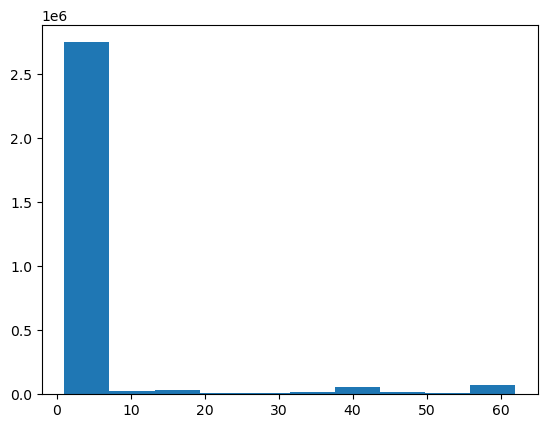

In [53]:
plt.hist(train_event_description.numpy())

tensor(1.)

In [7]:
train_data = torch.cat((month.unsqueeze(1), day_of_week.unsqueeze(1),day_since_paycheck.unsqueeze(1),
                        #store_nbr.unsqueeze(1),
                        family.unsqueeze(1),  onpromotion.unsqueeze(1),
                        dcoilwtico.unsqueeze(1),
                        city.unsqueeze(1), state.unsqueeze(1), store_type.unsqueeze(1), cluster.unsqueeze(1),
                        train_event_type.unsqueeze(1), train_event_description.unsqueeze(1)
                           ), dim=1)

print(train_data.dtype)
print(train_data.shape, train_data.dtype)
print(train_sales.shape, train_sales.dtype)

torch.float32
torch.Size([3000888, 12]) torch.float32
torch.Size([3000888]) torch.float32


In [8]:
# Shuffle the data and labels
indices = np.random.permutation(len(train_data))
train_data = train_data[indices]
train_sales = train_sales_log[indices]

# Define the percentage of data to be used for validation
val_percent = 0.2

# Calculate the number of validation samples
val_size = int(len(train_data) * val_percent)

# Split the data and labels into training and validation sets
val_data = train_data[:val_size]
train_data = train_data[val_size:]

val_sales = train_sales[:val_size]
train_sales = train_sales[val_size:]

print(val_data.shape)
print(val_sales.shape)
print(train_data.shape)
print(train_sales.shape)

torch.Size([600177, 12])
torch.Size([600177])
torch.Size([2400711, 12])
torch.Size([2400711])


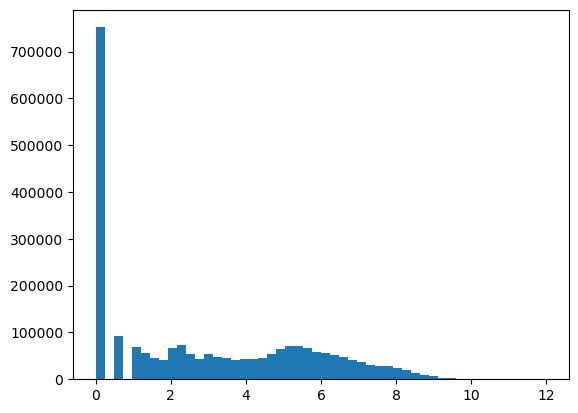

11.73381
std 2.6952431201934814
mean 2.9256398677825928
min 0.0
max 11.733810424804688


In [9]:
import matplotlib.pyplot as plt
data_range = train_sales.numpy().max() - train_sales.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales.numpy().max())+1)
plt.hist(train_sales.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(f'std {train_sales.std()}')
print(f'mean {train_sales.mean()}')
print(f'min {train_sales.min()}')
print(f'max {train_sales.max()}')

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [11]:
from torch import nn
import math

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        rmsle = self.mse(torch.log(pred + 1), torch.log(actual + 1)) 
        return rmsle


In [57]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SalesPredictor(nn.Module):
    def __init__(self):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(12, 48) 
        self.fc2 = nn.Linear(48, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 1, bias=False)
        self.Leaky_ReLu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.Leaky_ReLu(x)
        x = self.fc3(x)
        x = self.Leaky_ReLu(x)
        x = self.fc4(x)
        x = self.Leaky_ReLu(x)
        x = self.fc5(x)
        x = self.Leaky_ReLu(x)
        x = self.fc6(x)
        x = self.Leaky_ReLu(x)
        x = self.fc7(x)
        x = self.relu(x)
        return x
    
    # Instantiate the neural network
model = SalesPredictor()
print(model)

SalesPredictor(
  (fc1): Linear(in_features=12, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=1, bias=False)
  (Leaky_ReLu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
)


In [62]:
from torch.utils.data import TensorDataset, DataLoader
# Define the loss function and optimizer
criterion = RMSLELoss()
optimizer = optim.Adam(model.parameters())

# Convert the data and labels to PyTorch datasets
train_dataset = TensorDataset(train_data, train_sales)
val_dataset = TensorDataset(val_data, val_sales)
# Define batch size for training and validation dataloaders
batch_size = 1300
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=10)
save_every = 1
train_iterations = 200


In [63]:
running_loss_es = []

In [64]:
def train():
    for epoch in range(train_iterations):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            print (f'Training epoch {epoch}/{train_iterations} iteration {i}/{len(train_loader)}', end = '\r'),
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(-1)
            outputs = outputs.squeeze(-1)
            raw_out = outputs
            #returning to real values instead of logs
            labels = torch.exp(labels)-1
            outputs = torch.exp(outputs)-1
            loss = criterion(outputs, labels)
            if (math.isnan(loss)):
                print(f'inputs = {inputs}')
                print(f'outputs = {outputs}')
                print(f'raw outputs = {raw_out}')
                print(f'expected ={labels}')
                print(f'NaN error on epoch {epoch}\n')
                for param in model.parameters():
                    print(param.data)
                return
                break
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'\nEpoch {epoch} loss: {running_loss/len(train_loader)}')
        running_loss_es.append(running_loss/len(train_loader))
        if (epoch % save_every == 0):
            model_file_name = f'weights/model_weights_{epoch}.pth'
            print(f'Saving model as {model_file_name}')
            torch.save(model, model_file_name)
        torch.save(model, f'weights/model_weights_{train_iterations}.pth')
train()
print("Done")

Training epoch 0/200 iteration 1846/1847
Epoch 0 loss: 3.915348330251449
Saving model as weights/model_weights_0.pth
Training epoch 1/200 iteration 1846/1847
Epoch 1 loss: 2.4974614648349105
Saving model as weights/model_weights_1.pth
Training epoch 2/200 iteration 1846/1847
Epoch 2 loss: 1.7190607577707553
Saving model as weights/model_weights_2.pth
Training epoch 3/200 iteration 1846/1847
Epoch 3 loss: 1.5028676648493644
Saving model as weights/model_weights_3.pth
Training epoch 4/200 iteration 1846/1847
Epoch 4 loss: 1.3061048916758364
Saving model as weights/model_weights_4.pth
Training epoch 5/200 iteration 1846/1847
Epoch 5 loss: 1.3044969677666942
Saving model as weights/model_weights_5.pth
Training epoch 6/200 iteration 1846/1847
Epoch 6 loss: 1.4966494310657334
Saving model as weights/model_weights_6.pth
Training epoch 7/200 iteration 1846/1847
Epoch 7 loss: 1.271302651571595
Saving model as weights/model_weights_7.pth
Training epoch 8/200 iteration 1846/1847
Epoch 8 loss: 1.2

Training epoch 68/200 iteration 1846/1847
Epoch 68 loss: 0.6358242766658357
Saving model as weights/model_weights_68.pth
Training epoch 69/200 iteration 1846/1847
Epoch 69 loss: 0.6450487030604496
Saving model as weights/model_weights_69.pth
Training epoch 70/200 iteration 1846/1847
Epoch 70 loss: 0.6045064111303238
Saving model as weights/model_weights_70.pth
Training epoch 71/200 iteration 1846/1847
Epoch 71 loss: 0.6053865110157759
Saving model as weights/model_weights_71.pth
Training epoch 72/200 iteration 1846/1847
Epoch 72 loss: 0.6030284465972836
Saving model as weights/model_weights_72.pth
Training epoch 73/200 iteration 1846/1847
Epoch 73 loss: 0.6152581866683351
Saving model as weights/model_weights_73.pth
Training epoch 74/200 iteration 1846/1847
Epoch 74 loss: 0.5911653794239325
Saving model as weights/model_weights_74.pth
Training epoch 75/200 iteration 1846/1847
Epoch 75 loss: 0.645548990047746
Saving model as weights/model_weights_75.pth
Training epoch 76/200 iteration 1

Training epoch 135/200 iteration 1846/1847
Epoch 135 loss: 0.5442043055407602
Saving model as weights/model_weights_135.pth
Training epoch 136/200 iteration 1846/1847
Epoch 136 loss: 0.5426599634100311
Saving model as weights/model_weights_136.pth
Training epoch 137/200 iteration 1846/1847
Epoch 137 loss: 0.5396770186435873
Saving model as weights/model_weights_137.pth
Training epoch 138/200 iteration 1846/1847
Epoch 138 loss: 0.542246203843361
Saving model as weights/model_weights_138.pth
Training epoch 139/200 iteration 1846/1847
Epoch 139 loss: 0.5561577045859423
Saving model as weights/model_weights_139.pth
Training epoch 140/200 iteration 1846/1847
Epoch 140 loss: 0.5372499893921159
Saving model as weights/model_weights_140.pth
Training epoch 141/200 iteration 1846/1847
Epoch 141 loss: 0.540775959079951
Saving model as weights/model_weights_141.pth
Training epoch 142/200 iteration 1846/1847
Epoch 142 loss: 0.609835394779669
Saving model as weights/model_weights_142.pth
Training ep

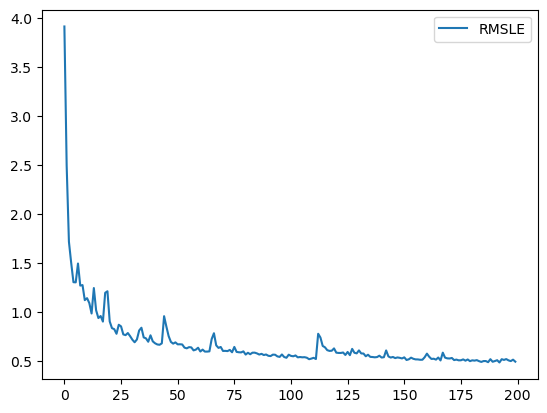

In [65]:
import matplotlib.pyplot as plt # for making figures
plt.plot(running_loss_es, label = "RMSLE")
plt.legend()

In [66]:
# Set the model to evaluation mode
model.eval()
machine_epsilon = 1
# Initialize the total loss and accuracy
total_loss = 0
total_correct = 0
total_samples = 0
machine_epsilon = train_sales_log.std()/10 
# Disable gradient calculation
with torch.no_grad():
    # Loop over the validation set
    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_labels = batch_labels.squeeze(-1)
        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        
        batch_labels = torch.exp(batch_labels)-1
        outputs = torch.exp(outputs)-1
        
        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        # Accumulate the loss
        total_loss += loss.item() * batch_data.size(0)

        # Get the predicted class
        
        
        # Count the number of correct predictions
        total_correct += ((
            (outputs - batch_labels)**2)<machine_epsilon).sum().item()

        # Increment the total number of samples
        total_samples += batch_data.size(0)
        #break
# Calculate the average loss and accuracy over the validation set
average_loss = total_loss / total_samples
accuracy = total_correct / total_samples

# Print the results
print('Validation Loss: {:.4f}'.format(average_loss))

Validation Loss: 0.5086


In [67]:
def evaluate(model_file, val_loader):
    # Load the neural network from file
    model = torch.load(model_file)
    print('Testing model ' + model_file)
    # Get the name of the model
    model_name = model_file.split("/")[-1]
    
    # Evaluate the neural network on the testing set
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
            # Loop over the validation set
        for batch_data, batch_labels in val_loader:
            # Move the data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_data)
            outputs = outputs.squeeze(-1)
            #batch_labels = torch.squeeze(-1)
            
            batch_labels = torch.exp(batch_labels)-1
            outputs = torch.exp(outputs)-1
        

            # Calculate the loss
            loss = criterion(outputs, batch_labels)
            
            # Accumulate the loss
            total_loss += loss.item() * batch_data.size(0)

            # Get the predicted class
            # Count the number of correct predictions
            total_correct += (
                    ((outputs - batch_labels)**2)<machine_epsilon).sum().item()
    
            # Increment the total number of samples
            total_samples += batch_data.size(0)

# Calculate the average loss and accuracy over the validation set
    average_loss = total_loss / total_samples
    #accuracy = total_correct / total_samples

# Print the results
    #accuracy = 0
    print('Validation Loss: {:.4f}'.format(average_loss))
    return average_loss

In [76]:
val_loss = []
num = []
#train_iterations = 1000
for i in range(train_iterations):
    if (i % save_every == 0):
        num.append(i)
        val_loss.append(evaluate(f'weights/model_weights_{i}.pth',val_loader))


Testing model weights/model_weights_0.pth
Validation Loss: 2.9761
Testing model weights/model_weights_1.pth
Validation Loss: 1.8976
Testing model weights/model_weights_2.pth
Validation Loss: 1.5173
Testing model weights/model_weights_3.pth
Validation Loss: 1.2616
Testing model weights/model_weights_4.pth
Validation Loss: 1.4285
Testing model weights/model_weights_5.pth
Validation Loss: 1.0720
Testing model weights/model_weights_6.pth
Validation Loss: 1.5596
Testing model weights/model_weights_7.pth
Validation Loss: 1.0837
Testing model weights/model_weights_8.pth
Validation Loss: 1.1474
Testing model weights/model_weights_9.pth
Validation Loss: 0.9856
Testing model weights/model_weights_10.pth
Validation Loss: 1.0069
Testing model weights/model_weights_11.pth
Validation Loss: 1.5775
Testing model weights/model_weights_12.pth
Validation Loss: 0.9620
Testing model weights/model_weights_13.pth
Validation Loss: 0.9490
Testing model weights/model_weights_14.pth
Validation Loss: 0.9534
Testi

Validation Loss: 0.6693
Testing model weights/model_weights_123.pth
Validation Loss: 0.6080
Testing model weights/model_weights_124.pth
Validation Loss: 0.6214
Testing model weights/model_weights_125.pth
Validation Loss: 0.5770
Testing model weights/model_weights_126.pth
Validation Loss: 0.6005
Testing model weights/model_weights_127.pth
Validation Loss: 0.5981
Testing model weights/model_weights_128.pth
Validation Loss: 0.5867
Testing model weights/model_weights_129.pth
Validation Loss: 0.6278
Testing model weights/model_weights_130.pth
Validation Loss: 0.6006
Testing model weights/model_weights_131.pth
Validation Loss: 0.5591
Testing model weights/model_weights_132.pth
Validation Loss: 0.5651
Testing model weights/model_weights_133.pth
Validation Loss: 0.5817
Testing model weights/model_weights_134.pth
Validation Loss: 0.5478
Testing model weights/model_weights_135.pth
Validation Loss: 0.5453
Testing model weights/model_weights_136.pth
Validation Loss: 0.6184
Testing model weights/mo

In [77]:
print(min(val_loss))


0.5043420225970919


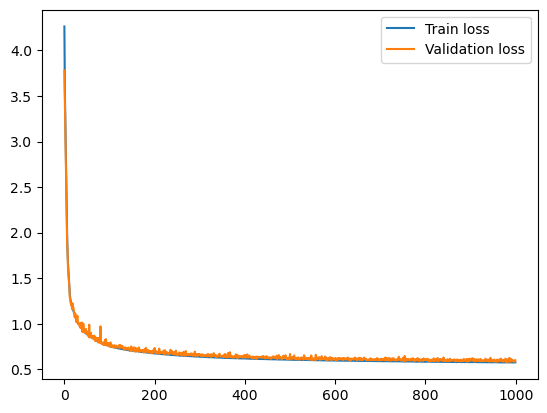

In [25]:
plt.plot(running_loss_es, label = "Train loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend()

In [20]:
!systemctl suspend

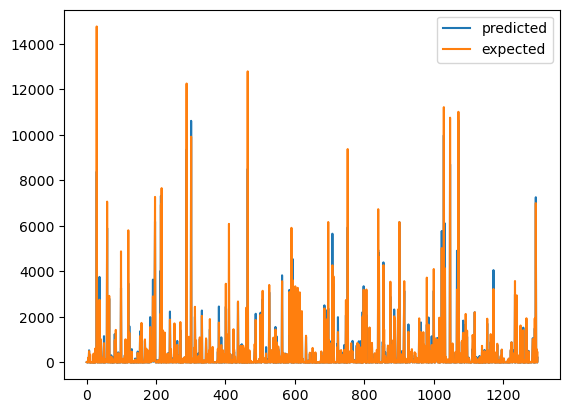

In [68]:
with torch.no_grad():

    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        #batch_labels = torch.squeeze(-1)

        batch_labels = torch.exp(batch_labels)-1
        outputs = torch.exp(outputs)-1


        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        plt.plot(outputs.numpy(), label = "predicted")
        plt.plot(batch_labels.numpy(), label = "expected")
        plt.legend()
        break

loss = 0.1499890238046646


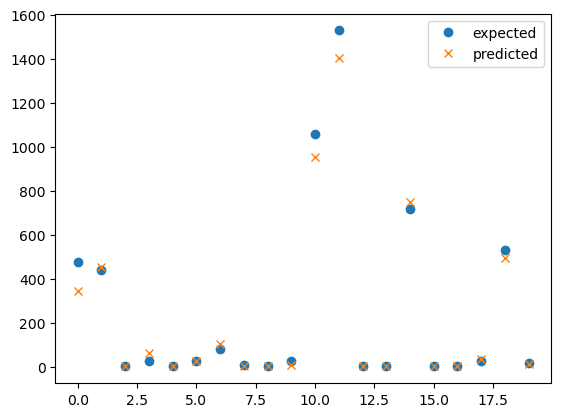

In [101]:
with torch.no_grad():
    evalutaion_val_dataset = val_loader.dataset
    n_samples = len(evalutaion_val_dataset)
    outputs = []
    expections = []
    for i in range(20):
    # Get a random sample
        random_index = int(np.random.random()*n_samples)
        single_example = evalutaion_val_dataset[random_index]
        output = model(single_example[0])
        output = torch.exp(output)+1
        outputs.append(output)
        expections.append(np.exp(single_example[1])+1)
        
    loss = criterion(torch.FloatTensor(outputs).squeeze(-1), torch.FloatTensor(expections).squeeze(-1))
    plt.plot(expections, label = "expected", linestyle="",marker="o")
    plt.plot(outputs, label = "predicted", linestyle="",marker="x")
    plt.legend()
    print(f'loss = {loss}')


In [88]:
model = torch.load('weights/model_weights_186.pth')

Commiting tests

In [102]:
import pandas as pd

# read the test.csv file
test_df = pd.read_csv('test.csv')

# read the oil.csv file
oil_df = pd.read_csv('oil.csv')

# fill missing values in dcoilwtico column with previous day's value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
test_merged_df = pd.merge(test_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
test_merged_df['dcoilwtico'] = test_merged_df['dcoilwtico'].fillna(method='ffill')





In [105]:
# Load the CSV file using pandas
test_train_df = pd.read_csv('test.csv')
test_oil_df = pd.read_csv('oil.csv')
test_stores_df = pd.read_csv('stores.csv')
# fill missing values in dcoilwtico column with previous day's value
test_oil_df['dcoilwtico'] = test_oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
test_merged_df = pd.merge(test_train_df, test_oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
test_merged_df['dcoilwtico'] = test_merged_df['dcoilwtico'].fillna(method='ffill')
test_merged_df = pd.merge(test_merged_df, test_stores_df, on='store_nbr').sort_values(by='id')

test_df = test_merged_df

# Extract the label column and convert to a PyTorch tensor
test_ids = torch.tensor(test_df['id'].values, dtype=torch.float)
#date = torch.tensor(df['date'].values)
test_store_nbr = torch.tensor(test_df['store_nbr'].values)
#test_train_sales = torch.tensor(test_df['sales'].values, dtype=torch.float)
test_onpromotion = torch.tensor(test_df['onpromotion'].values)
test_dcoilwtico = torch.tensor(test_df['dcoilwtico'].values, dtype=torch.float)

test_df['event_type'] = 'regular day'
test_df['description'] = '0'
for index, row in test_df.iterrows():
    if (row['date'] in data_dict):
        if (row['city'] in data_dict[row['date']]):
            test_df.at[index, 'description'] = data_dict[row['date']][row['city']]['description']
            test_df.at[index, 'event_type'] =  data_dict[row['date']][row['city']]['type']
        if (row['state'] in data_dict[row['date']]):
            test_df.at[index, 'description'] = data_dict[row['date']][row['state']]['description']
            test_df.at[index, 'event_type']  = data_dict[row['date']][row['state']]['type']
        if ('Ecuador' in data_dict[row['date']]):
                test_df.at[index, 'description'] = data_dict[row['date']]['Ecuador']['description']
                test_df.at[index, 'event_type'] = data_dict[row['date']]['Ecuador']['type']
    else:
        test_df.at[index, 'event_type'] = "regular day"

# Convert string dates to datetime objects
test_dates = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
test_month = []
test_day_of_week = []
test_day_of_month = []
test_day_since_paycheck = []
for i in test_dates:
    test_month.append(i.month)
    test_day_of_week.append(i.day_of_week + 1)
    num_days_in_month = monthrange(i.year, i.month)[1]
    test_day_of_month.append(i.day)
    if(num_days_in_month == i.day):
        test_day_since_paycheck.append(0)
    else:
        if (i.day>=15):
            test_day_since_paycheck.append(i.day-15)
        else:
            test_day_since_paycheck.append(i.day)

test_month = torch.FloatTensor(test_month)
test_day_of_week = torch.FloatTensor(test_day_of_week)
test_day_since_paycheck = torch.FloatTensor(test_day_since_paycheck)
test_day_of_month = torch.FloatTensor(test_day_of_month)

#family to tensor
test_family = []
test_family_raw = test_df['family'].values
test_families = sorted(list(set(test_family_raw)))
test_family_stoi = {s:i+1 for i,s in enumerate(test_families)}
for i in test_family_raw:
    test_family.append(family_stoi[i])
test_family = torch.FloatTensor(test_family)

#city to tensor
test_city = []
test_city_raw = test_df['city'].values
test_cities = sorted(list(set(city_raw)))
test_cities_stoi = {s:i+1 for i,s in enumerate(cities)}
#cities_itos = {i:s for s,i in cities_stoi.items()}
for i in test_city_raw:
    test_city.append(test_cities_stoi[i])
test_city = torch.FloatTensor(test_city)

#state to tensor
#test_state_raw = test_df['state'].values
#test_state = []
#test_states = sorted(list(set(test_state_raw)))
#test

#state to tensor
test_state_raw = test_df['state'].values
test_state = []
#states = sorted(list(set(state_raw)))
#states_stoi = {s:i+1 for i,s in enumerate(states)}
for i in test_state_raw:
    test_state.append(states_stoi[i])
test_state = torch.FloatTensor(test_state)

#store type to tensor
test_store_type_raw = test_df['type'].values
test_store_type = []
#store_types = sorted(list(set(store_type_raw)))
#store_types_stoi = {s:i+1 for i,s in enumerate(store_types)}
for i in test_store_type_raw:
    test_store_type.append(store_types_stoi[i])
test_store_type = torch.FloatTensor(test_store_type)

test_event_description_raw = test_df['description']
test_event_description = []
#event_descriptions = sorted(list(set(test_event_description_raw)))
#event_descriptions_stoi = {s:i+1 for i,s in enumerate(event_descriptions)}
for i in test_event_description_raw:
    test_event_description.append(event_descriptions_stoi[i])
test_event_description = torch.FloatTensor(test_event_description)


test_event_type_raw = test_df['event_type']
test_event_type = []
#event_types = sorted(list(set(test_event_type_raw)))
#event_types_stoi = {s:i+1 for i,s in enumerate(event_types)}
for i in test_event_type_raw:
    test_event_type.append(event_types_stoi[i])
test_event_type = torch.FloatTensor(test_event_type)


test_cluster = torch.tensor(test_df['cluster'].values, dtype=torch.float)

In [106]:
#print(train_sales.shape, train_sales.dtype)
print(test_store_nbr.shape, test_store_nbr.dtype)
print(test_onpromotion.shape, test_onpromotion.dtype)
print(test_family.shape, test_family.dtype)
print(test_day_of_week.shape, day_of_week.dtype)
print(test_month.shape, test_month.dtype)
print(test_day_since_paycheck.shape, test_day_since_paycheck.dtype)
print(test_dcoilwtico.shape, dcoilwtico.dtype)
print(test_city.shape, test_city.dtype)
print(test_state.shape, test_state.dtype)
print(test_store_type.shape, test_store_type.dtype)
print(test_cluster.shape, test_cluster.dtype)

torch.Size([28512]) torch.int64
torch.Size([28512]) torch.int64
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32


In [107]:
test_data = torch.cat((test_month.unsqueeze(1), test_day_of_week.unsqueeze(1),test_day_since_paycheck.unsqueeze(1),
                        #test_store_nbr.unsqueeze(1),
                       test_family.unsqueeze(1),  test_onpromotion.unsqueeze(1),
                        test_dcoilwtico.unsqueeze(1),
                       test_city.unsqueeze(1), test_state.unsqueeze(1), test_store_type.unsqueeze(1), test_cluster.unsqueeze(1),
                       test_event_type.unsqueeze(1), test_event_description.unsqueeze(1)
                           ), dim=1)

print(test_data.dtype)
print(test_data.shape, test_data.dtype)
print(test_data.shape, test_data.dtype)

torch.float32
torch.Size([28512, 12]) torch.float32
torch.Size([28512, 12]) torch.float32


In [108]:
all_predictions = []
submission_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=8)
with torch.no_grad():
    for i, (inputs) in enumerate(submission_loader):
        outputs = model(inputs)
        output = torch.exp(outputs)+1
        #_,predicted = torch.max(outputs.data, 1)
        all_predictions.append(output.item())
        #all_predictions.extend(predicted.numpy())
# Save the predictions to a new CSV file
startId = 3000888
#endId = 
results = [i for i in range(startId,3000888+len(all_predictions))]
df = pd.DataFrame({'id': results, 'sales': all_predictions})
df.to_csv('My_model_predictions.csv', index=False)

In [109]:
all_predictions

[5.7494797706604,
 2.0108585357666016,
 7.471561431884766,
 2201.96044921875,
 2.0,
 456.844970703125,
 12.667123794555664,
 903.3385620117188,
 717.33349609375,
 205.02529907226562,
 156.75616455078125,
 114.1637191772461,
 3919.492431640625,
 28.02021026611328,
 3.118501663208008,
 25.03166961669922,
 37.39282989501953,
 2.0,
 243.6207275390625,
 21.259597778320312,
 43.72578811645508,
 12.225469589233398,
 106.04676055908203,
 5.57415771484375,
 375.65850830078125,
 253.1753387451172,
 7.492336750030518,
 8.703076362609863,
 346.5980224609375,
 103.52830505371094,
 7888.984375,
 197.961181640625,
 24.66802406311035,
 4.372576713562012,
 2.3363442420959473,
 4.0121002197265625,
 1110.299072265625,
 2.0,
 95.30215454101562,
 3.9095563888549805,
 632.7579345703125,
 478.3666687011719,
 270.1260986328125,
 35.646766662597656,
 31.887653350830078,
 3114.7109375,
 3.909870147705078,
 2.2394700050354004,
 12.137094497680664,
 12.945199966430664,
 2.0,
 166.36383056640625,
 5.42735624313354

In [46]:
test_event_description

tensor([1., 1., 1.,  ..., 1., 1., 1.])

(array([28446.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    66.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

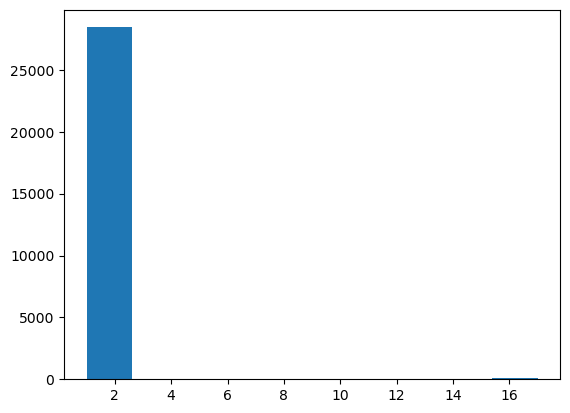

In [110]:
plt.hist(test_event_description.numpy())


(array([   66.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 28446.]),
 array([4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

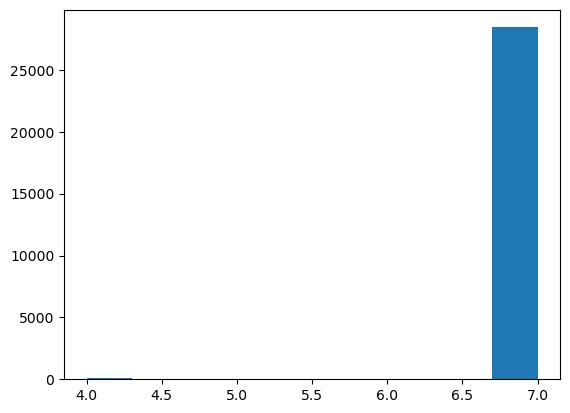

In [111]:
plt.hist(test_event_type.numpy())

In [113]:
test_event_type.max()

tensor(7.)

In [115]:
test_event_type.max()

tensor(7.)